In [1]:
from mixtral.modeling_mixtral import MixtralForCausalLM
from transformers import AutoTokenizer
import torch
from copy import deepcopy
from tqdm import tqdm

/home/mengfanxu/miniconda3/envs/transmla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from mixtral.configuration_mixtral import MixtralConfig
config = MixtralConfig(num_hidden_layers=1)

In [3]:
model = MixtralForCausalLM(config=config)

In [4]:
model = MixtralForCausalLM.from_pretrained("/data2/mengfanxu/huggingface/Llama-3.2-1B-Instruct", attn_implementation="eager", device_map='cuda:0')
tokenizer = AutoTokenizer.from_pretrained("/data2/mengfanxu/huggingface/Llama-3.2-1B-Instruct")
model

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): MixtralDecoderLayer(
        (self_attn): MixtralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear(in_features=4096, out_features=14336, bias=False)
              (w2): Linear(in_features=14336, out_features=4096, bias=False)
              (w3): Linear(in_features=4096, out_features=14336, bias=False)
            

In [4]:
hidden_size = model.config.hidden_size
n_heads = model.config.num_attention_heads
kv_heads = model.config.num_key_value_heads
head_dim = hidden_size//n_heads
kv_groups = model.config.num_attention_heads // model.config.num_key_value_heads

In [5]:
# Insert identity matrices
for name,module in model.named_modules():
    if 'k_up_proj' in name or "v_up_proj" in name:
        module.weight.data = torch.stack([torch.eye(kv_heads*head_dim).reshape(kv_heads, head_dim, kv_heads*head_dim)]*kv_groups,dim=1).reshape(hidden_size, kv_heads*head_dim).contiguous().to(module.weight.data.device,module.weight.data.dtype)

In [11]:
x = torch.randint(0,100,(1,15))
output = model.generate(x)
output

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor([[   91,    60,    83,    49,    94,    51,    25,    16,    35,    95,
            66,    92,    82,    80,    16, 17473, 21602,  4043,  9100, 20758]])

In [11]:
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

NameError: name 'tokenizer' is not defined

In [12]:
for name,module in tqdm(model.named_modules()):
    if name.endswith("self_attn"):
        # Orthogonal k_proj and k_up_proj
        k_up_weight = deepcopy(module.k_up_proj.weight.data).reshape(hidden_size, kv_heads, head_dim) # (hidden_size, kv_heads, head_dim)
        k_weight = deepcopy(module.k_proj.weight.data).reshape(kv_heads, head_dim, hidden_size) # (kv_heads, head_dim, hidden_size)
        if module.k_proj.bias is not None:
            k_weight = torch.cat([k_weight,deepcopy(module.k_proj.bias.data).reshape(kv_heads, head_dim,1)],dim=-1)
        k_up_k = torch.einsum("Dhd,hdL->hDL",k_up_weight, k_weight) # (kv_heads, hidden_size, hidden_size), rank<=head_dim
        U,S,V = torch.svd_lowrank(k_up_k, head_dim, niter=head_dim) # U(kv_heads, hidden_size, head_dim), S(kv_heads, head_dim), V(kv_heads, hidden_size, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (latent_dim, kv_heads, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (kv_heads, head_dim, latent_dim)
        if module.k_proj.bias is not None:
            module.k_proj.bias.data = S_sqrtV[:,:,-1].reshape(-1).contiguous()
            S_sqrtV = S_sqrtV[:,:,:-1]
        module.k_up_proj.weight.data = US_sqrt.reshape(hidden_size, kv_heads*head_dim).contiguous()
        module.k_proj.weight.data = S_sqrtV.reshape(kv_heads*head_dim, hidden_size).contiguous()
        # Orthogonal v_proj and v_up_proj
        v_up_weight = deepcopy(module.v_up_proj.weight.data).reshape(hidden_size, kv_heads, head_dim) # (hidden_size, kv_heads, head_dim)
        v_weight = deepcopy(module.v_proj.weight.data).reshape(kv_heads, head_dim, hidden_size) # (kv_heads, head_dim, hidden_size)
        if module.v_proj.bias is not None:
            v_weight = torch.cat([v_weight,deepcopy(module.v_proj.bias.data).reshape(kv_heads, head_dim,1)],dim=-1)
        v_up_v = torch.einsum("Dhd,hdL->hDL",v_up_weight, v_weight) # (kv_heads, hidden_size, hidden_size), rank<=head_dim
        U,S,V = torch.svd_lowrank(v_up_v, head_dim, niter=head_dim) # U(kv_heads, hidden_size, head_dim), S(kv_heads, head_dim), V(kv_heads, hidden_size, head_dim)
        US_sqrt = torch.einsum('hDd,hd->Dhd',U,torch.sqrt(S)) # (latent_dim, kv_heads, head_dim)
        S_sqrtV = torch.einsum('hd,hLd->hdL',torch.sqrt(S),V) # (kv_heads, head_dim, latent_dim)
        if module.v_proj.bias is not None:
            module.v_proj.bias.data = S_sqrtV[:,:,-1].reshape(-1).contiguous()
            S_sqrtV = S_sqrtV[:,:,:-1]
        module.v_up_proj.weight.data = US_sqrt.reshape(hidden_size, kv_heads*head_dim).contiguous()
        module.v_proj.weight.data = S_sqrtV.reshape(kv_heads*head_dim, hidden_size).contiguous()

5it [00:00, 32413.48it/s]

AttributeError: 'MixtralSdpaAttention' object has no attribute 'k_up_proj'

In [ ]:
output = model.generate(x)
output

In [7]:
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['<|begin_of_text|>Give me a short introduction to large language model. Explain how they work and what their strengths and']

In [10]:
model.save_pretrained("llama3.2_1b_instruct_transMLA")
#model.push_to_hub("fxmeng/llama3.2_1b_instruct_transMLA")

In [3]:
tokenizer.save_pretrained("llama3.2_1b_instruct_transMLA")
#tokenizer.push_to_hub("fxmeng/llama3.2_1b_instruct_transMLA")

('llama3.2_1b_instruct_transMLA/tokenizer_config.json',
 'llama3.2_1b_instruct_transMLA/special_tokens_map.json',
 'llama3.2_1b_instruct_transMLA/tokenizer.json')

In [11]:
model = LlamaForCausalLM.from_pretrained("fxmeng/llama3.2_1b_instruct_transMLA", attn_implementation="eager", device_map='cuda:0')
tokenizer = AutoTokenizer.from_pretrained("fxmeng/llama3.2_1b_instruct_transMLA")
output = model.generate(**tokenizer("Give me a short introduction to large language model.",return_tensors="pt").to("cuda:0"))
tokenizer.batch_decode(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/home/mfx/miniconda3/envs/bitsfit/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['<|begin_of_text|>1+1=2\nI love my life.\nThe phrase "1+1=2']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["white", "blue"])

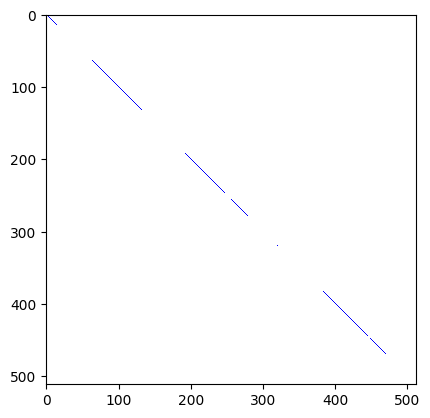

In [38]:
v_weight = model.model.layers[0].self_attn.v_proj.weight.data.to("cpu")
plt.imshow(v_weight@v_weight.T, cmap=cmap, interpolation='none')

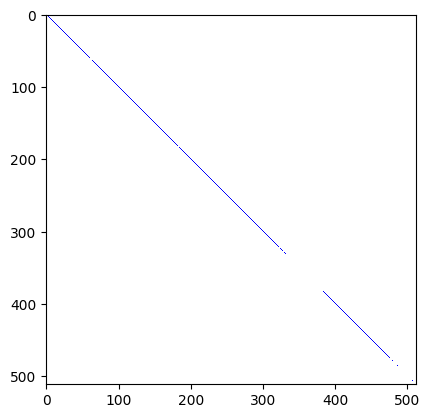

In [40]:
v_up_weight = model.model.layers[0].self_attn.v_up_proj.weight.data.to("cpu")
plt.imshow(v_up_weight.T@v_up_weight, cmap=cmap, interpolation='none')